In [225]:
import pandas as pd
import sys

sys.path.append('~/PycharmProjects/Boston_housing/')

df_master = pd.read_csv('./data/' + 'redfin_2020-01-19-08-17-26.csv')
df_master.pop('SOLD DATE')
df_condo = pd.read_csv('./data/' + 'Boston_condo_transaction.csv',index_col=0)
df_sfr = pd.read_csv('./data/' + 'Boston_single_family_residential_transaction.csv',index_col=0)
df_townhouse = pd.read_csv('./data/' + 'Boston_townhouse_transaction.csv',index_col=0)

df_transaction = pd.concat([df_condo,df_sfr,df_townhouse])

df = df_master.join(df_transaction,how='inner')


# Drop outlier that is beyond the Q3+1.5*IQR

Justify the drop. How many of them are due to typo and how many are genuine?

number of data before outlier removal:  7912
number of data after outlier removal:  6048
number of data after removing new data:  6046


<IPython.core.display.Javascript object>


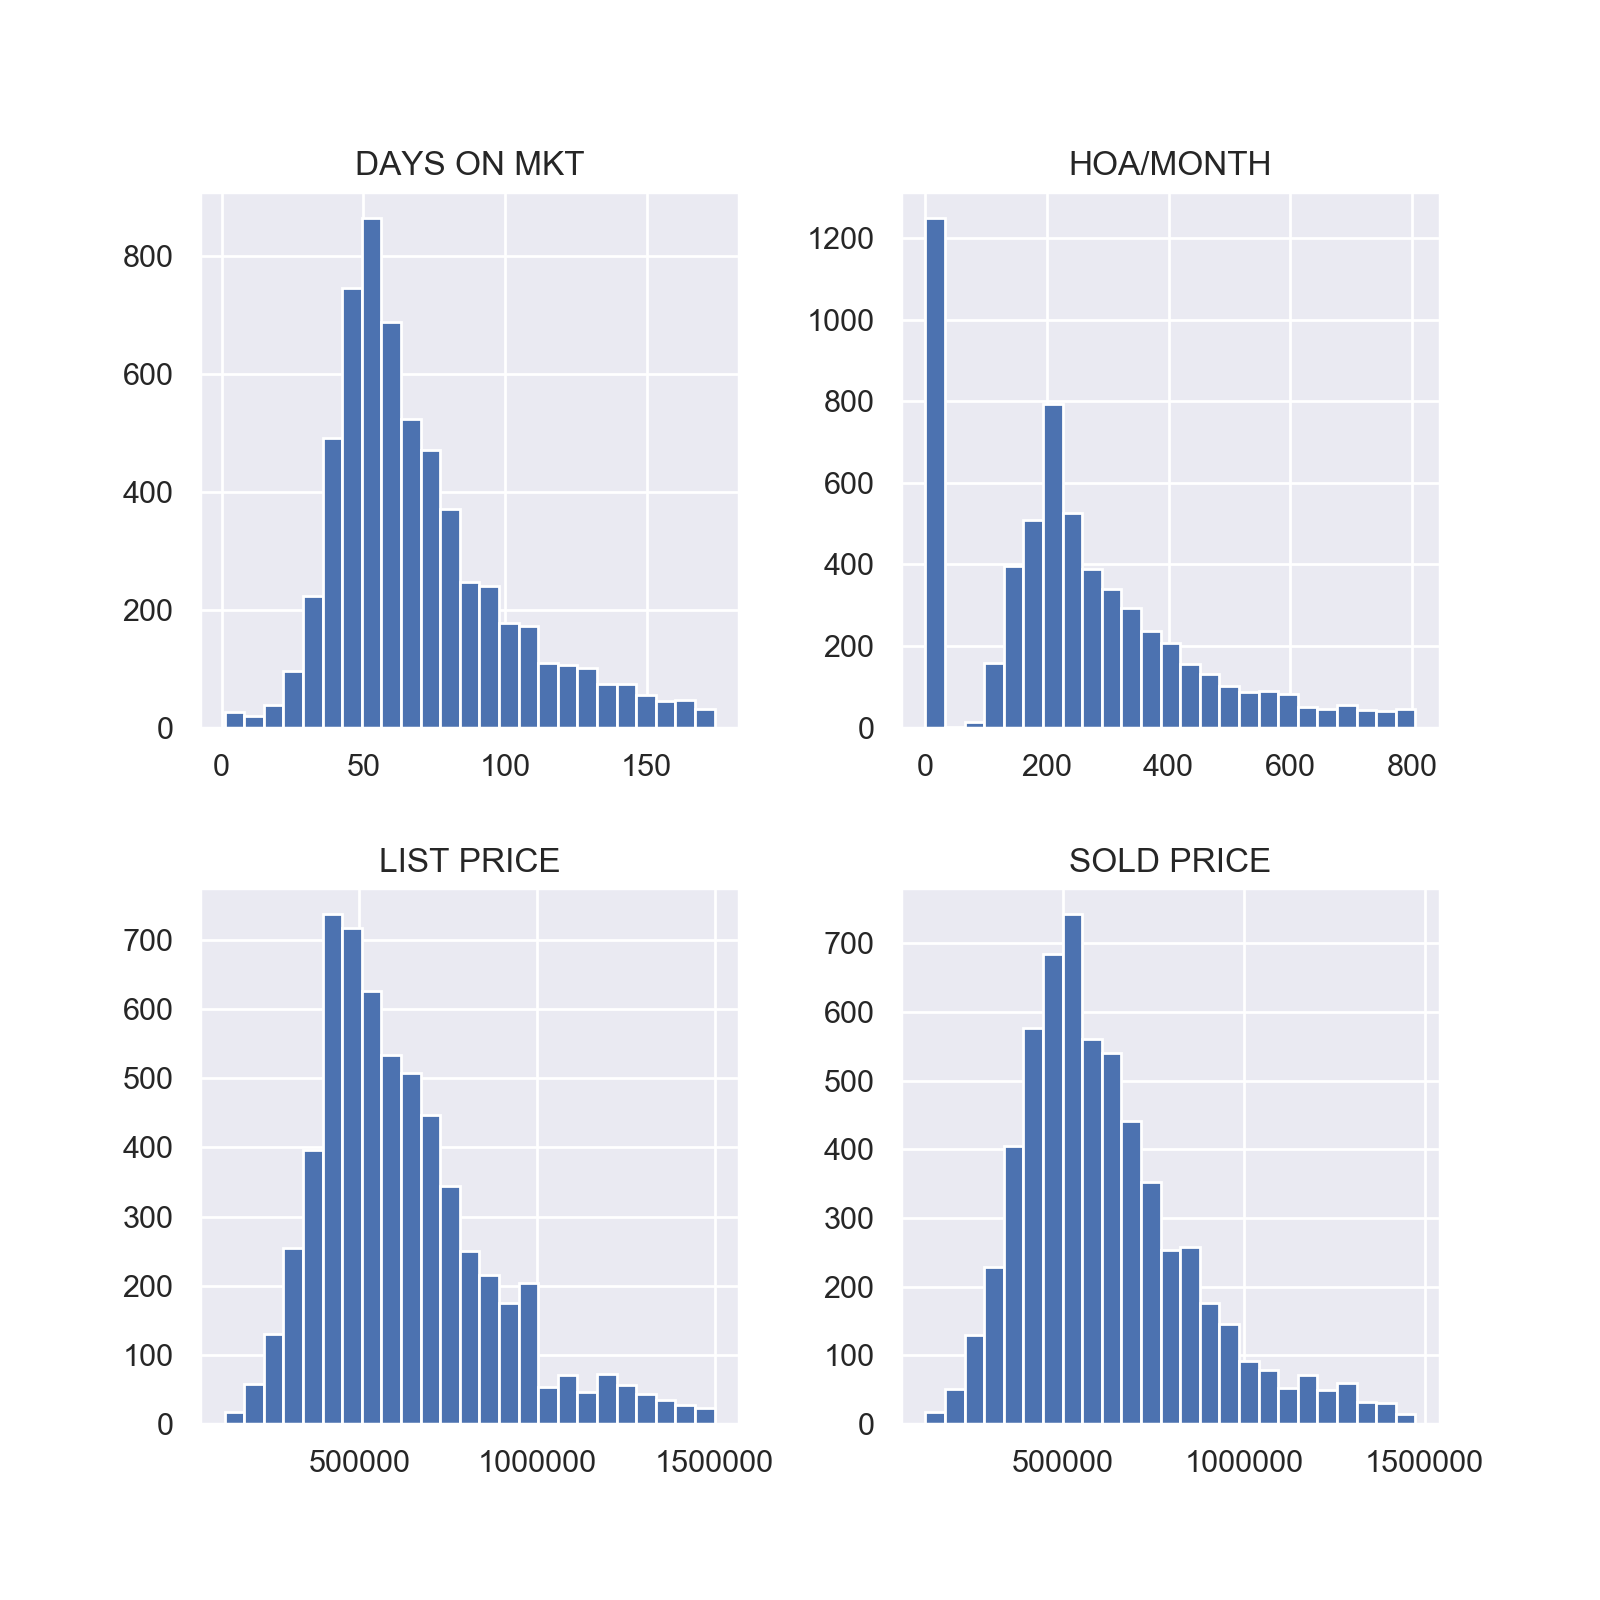

In [226]:
def upper_outlier(x):
    return  np.quantile(x,0.75) + 1.5*(np.quantile(x,0.75)-np.quantile(x,0.25))

def lower_outlier(x):
    return  np.quantile(x,0.25) - 1.5*(np.quantile(x,0.75)-np.quantile(x,0.25))

df['SOLD DATE'] = pd.to_datetime(df['SOLD DATE'])
df['LIST DATE'] = pd.to_datetime(df['LIST DATE'])
df['DAYS ON MKT'] = (df['SOLD DATE'] - df['LIST DATE']).apply(lambda x: x.days)
df['HOA/MONTH'] = df['HOA/MONTH'].fillna(0)
df['PREMIUM'] = (df['SOLD PRICE'] - df['LIST PRICE'])/df['LIST PRICE']

df_upper_outlier = df[['DAYS ON MKT','SOLD PRICE','LIST PRICE','HOA/MONTH','PREMIUM']].apply(
    lambda x: upper_outlier(x),axis=0)
df_lower_outlier = df[['DAYS ON MKT','SOLD PRICE','LIST PRICE','HOA/MONTH','PREMIUM']].apply(
    lambda x: lower_outlier(x),axis=0)

print('number of data before outlier removal: ',len(df))

df = df[(df['DAYS ON MKT'] < df_upper_outlier['DAYS ON MKT'])&
        (df['SOLD PRICE'] < df_upper_outlier['SOLD PRICE']) &
        (df['LIST PRICE'] < df_upper_outlier['LIST PRICE']) &
        (df['HOA/MONTH'] < df_upper_outlier['HOA/MONTH']) &
        (df['PREMIUM'] < df_upper_outlier['PREMIUM']) &
        (df['DAYS ON MKT'] > df_lower_outlier['DAYS ON MKT']) &
        (df['SOLD PRICE'] > df_lower_outlier['SOLD PRICE']) & 
        (df['LIST PRICE'] > df_lower_outlier['LIST PRICE']) &
        (df['PREMIUM'] > df_lower_outlier['PREMIUM'])]


print('number of data after outlier removal: ',len(df))

df = df[df['DAYS ON MKT'] > 0] # price history scraped after the spreadsheet
df = df[np.abs((df['SOLD PRICE']-df['LIST PRICE'])/df['LIST PRICE']) < 1] # typo in listing/selling price

print('number of data after removing new data: ',len(df))


ax_list = df[['DAYS ON MKT','SOLD PRICE','LIST PRICE','HOA/MONTH']].hist(
    bins=25, layout=(2,2), figsize=(8,8))

<IPython.core.display.Javascript object>


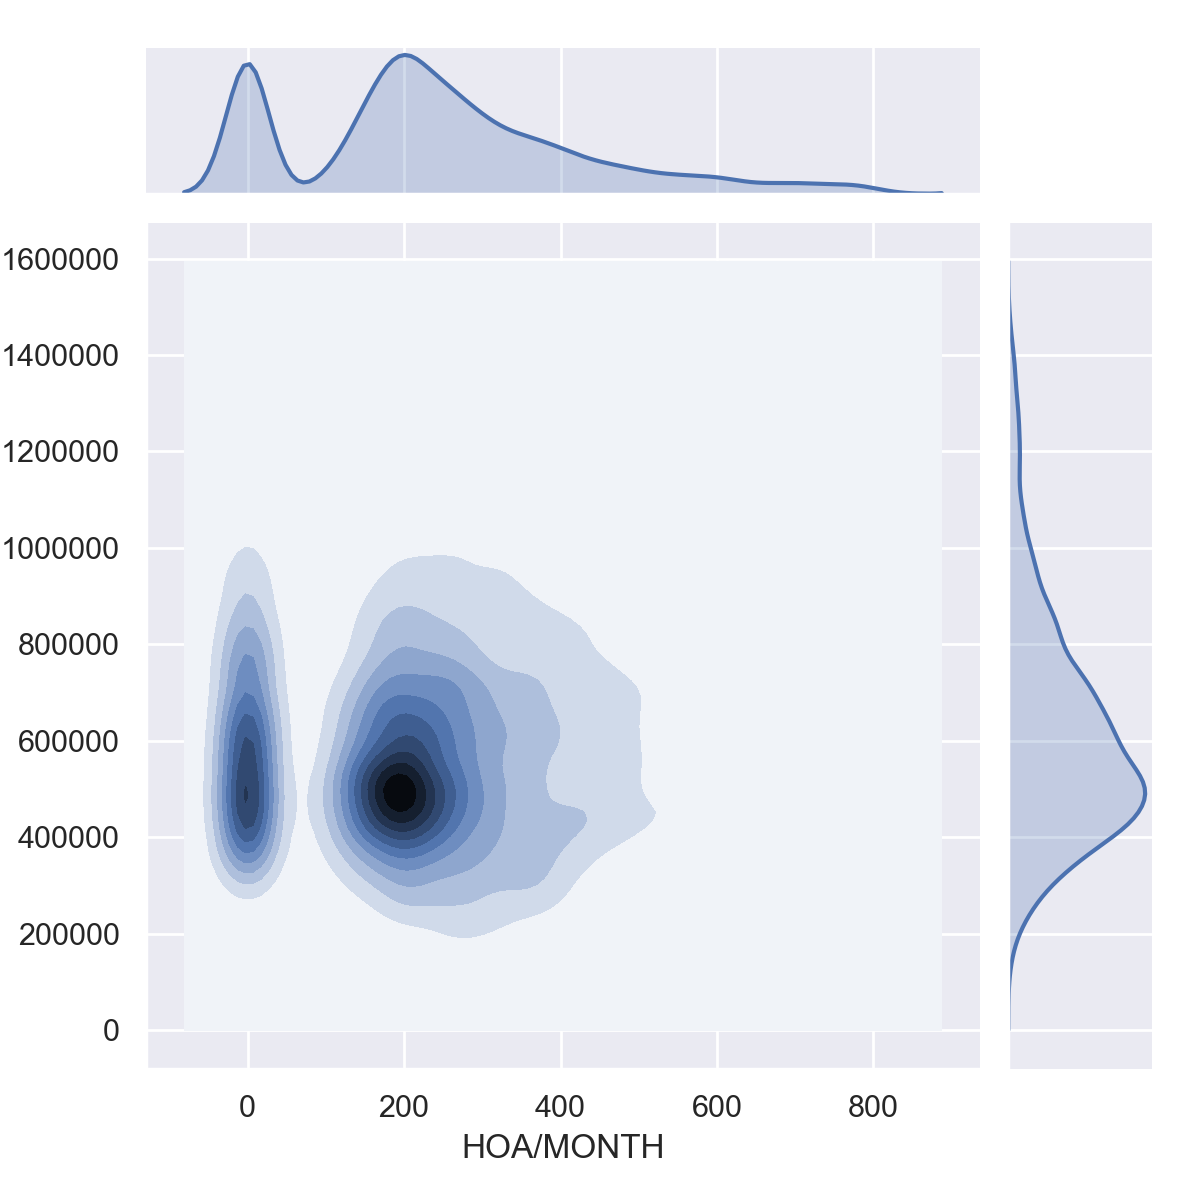

In [227]:
import matplotlib.pyplot as plt
%matplotlib notebook

import seaborn as sns

sns.set()


df_joint = df[['HOA/MONTH','SOLD PRICE']]
#df_joint = np.log(df_joint)

sns.jointplot('HOA/MONTH', "SOLD PRICE", data=df_joint,
             #marginal_kws=dict(bins=100, rug=True),
             kind='kde')

plt.show()

<IPython.core.display.Javascript object>


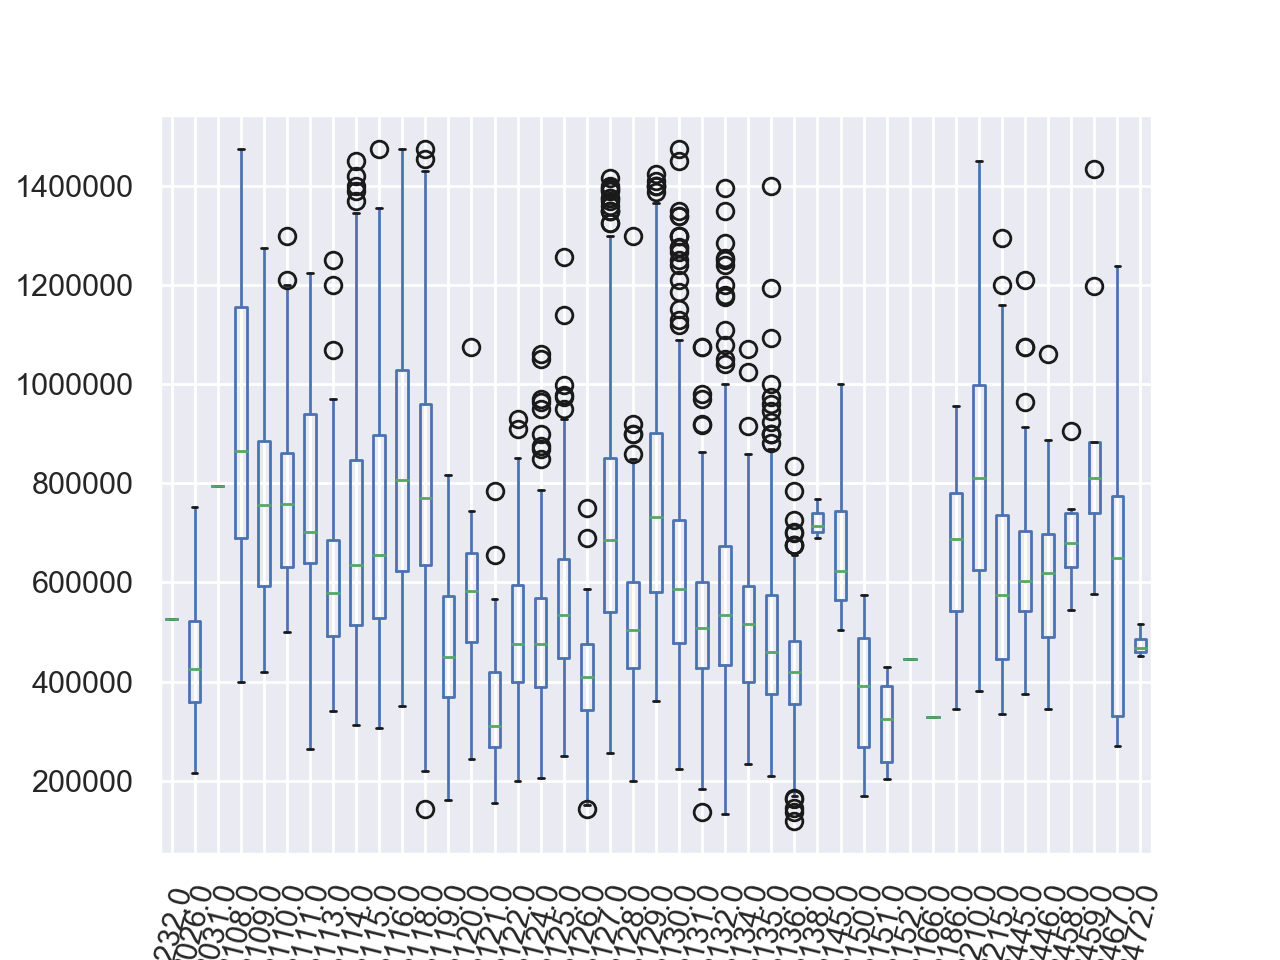

In [228]:
df_core = df[['DAYS ON MKT','SOLD PRICE','LIST PRICE','HOA/MONTH','ZIP OR POSTAL CODE']]

df_pivot = df_core.pivot(columns='ZIP OR POSTAL CODE',values='SOLD PRICE')

fig = plt.figure()
df_pivot.boxplot(column=df_pivot.columns.tolist())
plt.xticks(rotation=76)
plt.ylabel('SOLD PRICE')
plt.show()



<IPython.core.display.Javascript object>


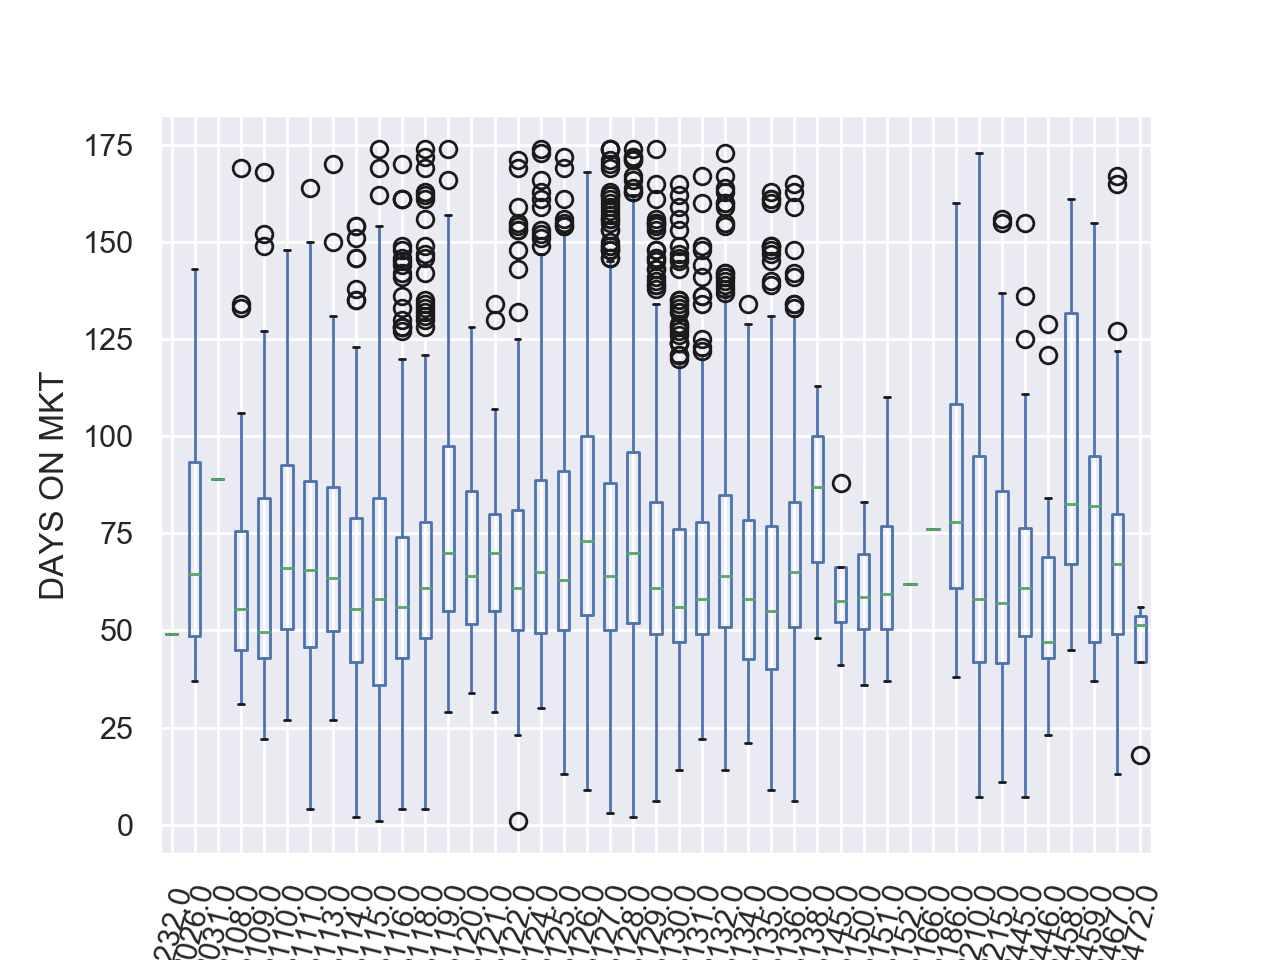

In [229]:
df_pivot = df_core.pivot(columns='ZIP OR POSTAL CODE',values='DAYS ON MKT')

fig = plt.figure()
df_pivot.boxplot(column=df_pivot.columns.tolist())
plt.xticks(rotation=76)
plt.ylabel('DAYS ON MKT')
plt.show()

1158


<IPython.core.display.Javascript object>


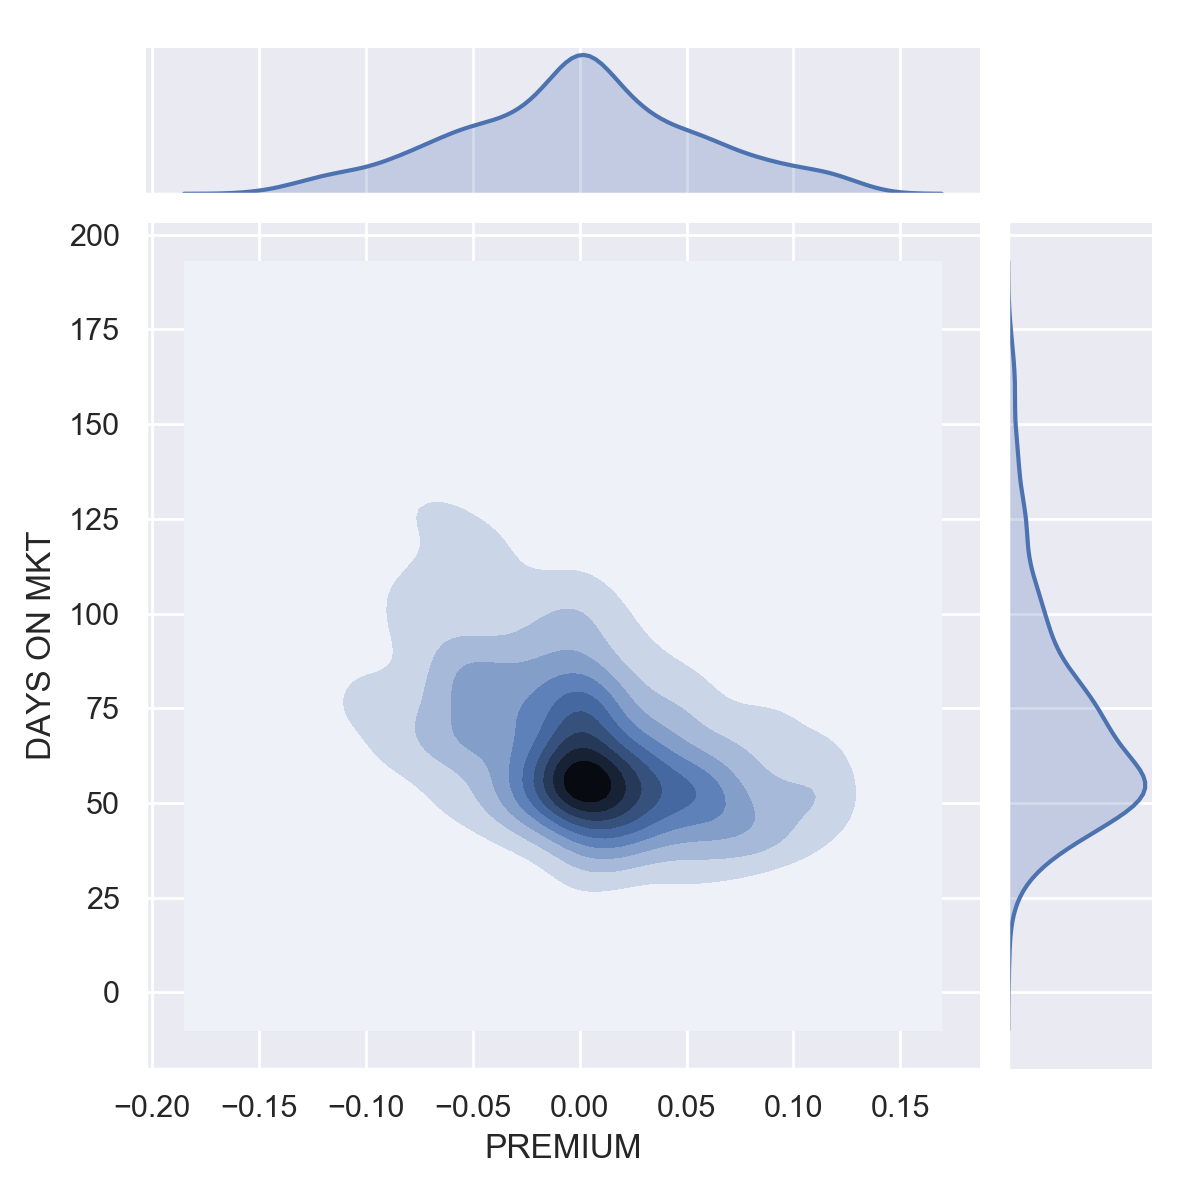

In [230]:
df_prop = df[df['PROPERTY TYPE']=='Single Family Residential']
print(len(df_prop))

sns.jointplot('PREMIUM', "DAYS ON MKT", data=df_prop,
             #marginal_kws=dict(bins=100, rug=True),
             kind='kde')

<IPython.core.display.Javascript object>


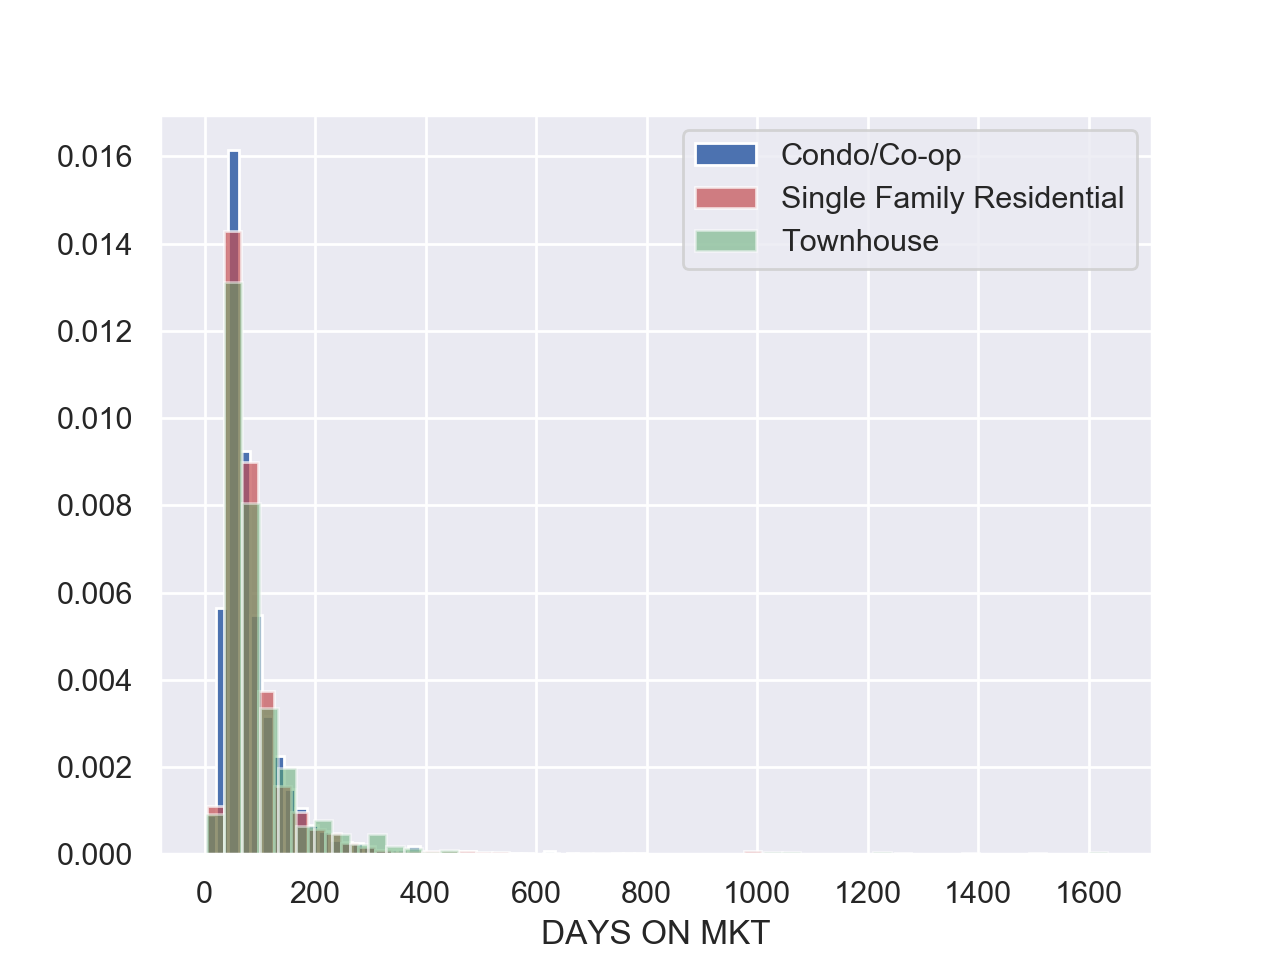

//anaconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<IPython.core.display.Javascript object>


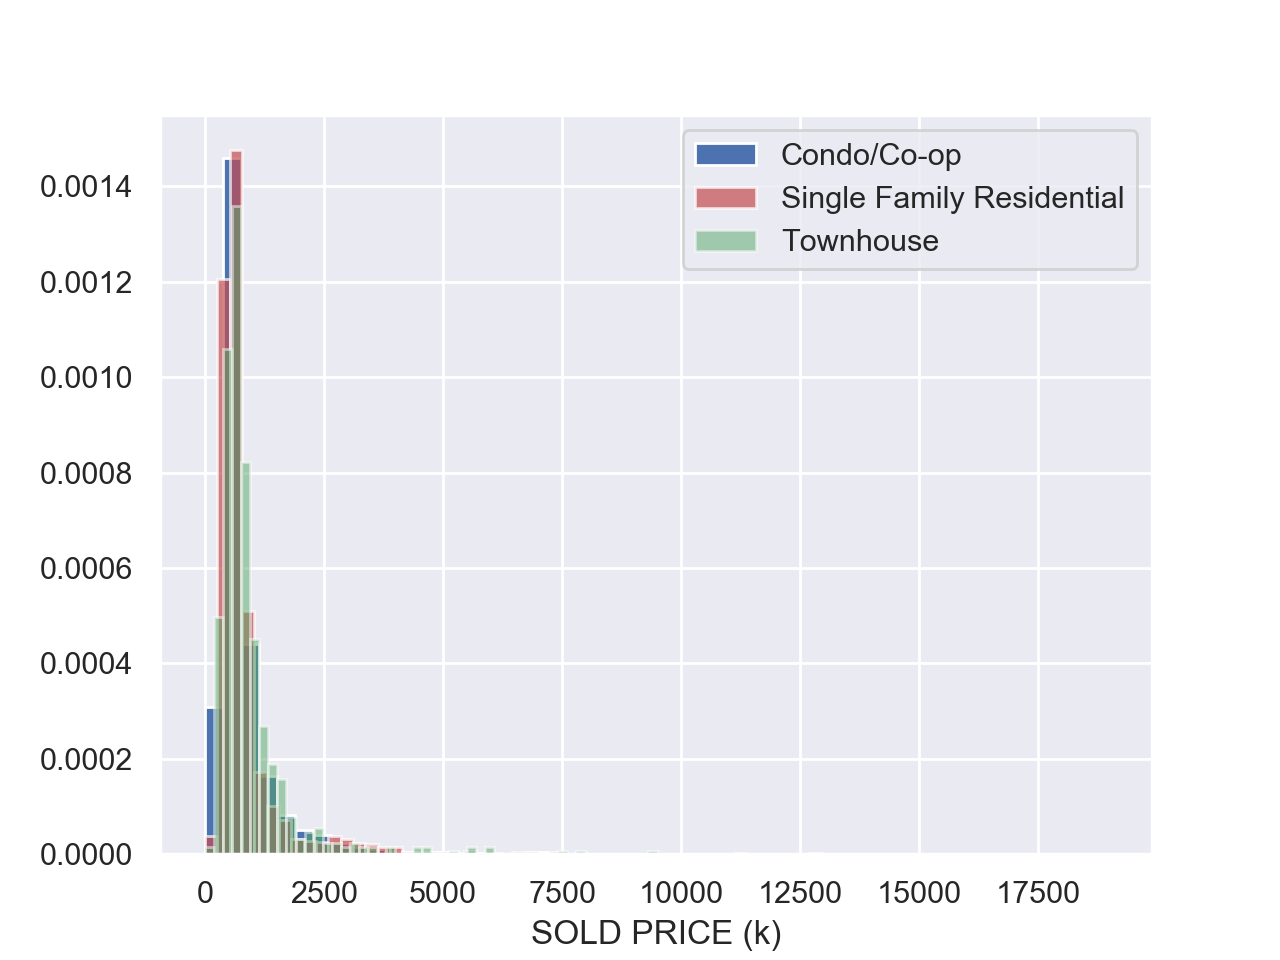

In [92]:
fig = plt.figure()
plt.hist(days_on_mkt[0],bins=50,color='b',label=property_types[0],normed=True)
plt.hist(days_on_mkt[1],bins=50,color='r',label=property_types[1],normed=True,alpha=0.7)
plt.hist(days_on_mkt[2],bins=50,color='g',label=property_types[2],normed=True,alpha=0.5)
plt.legend(loc='best')
plt.xlabel('DAYS ON MKT')
plt.draw()

fig = plt.figure()
plt.hist(sold_price[0]/1000,bins=50,color='b',label=property_types[0],normed=True)
plt.hist(sold_price[1]/1000,bins=50,color='r',label=property_types[1],normed=True,alpha=0.7)
plt.hist(sold_price[2]/1000,bins=50,color='g',label=property_types[2],normed=True,alpha=0.5)
plt.legend(loc='best')
plt.xlabel('SOLD PRICE (k)')
plt.show()


In [165]:
from scipy.stats import ks_2samp

days_on_mkt_ks_p_values = np.zeros((3,3))
sold_price_ks_p_values = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        days_on_mkt_ks_p_values[i][j] = ks_2samp(days_on_mkt[i],days_on_mkt[j])[1]
        sold_price_ks_p_values[i][j] = ks_2samp(sold_price[i],sold_price[j])[1]

print('DAYS OF MKT KS p-value')
print(days_on_mkt_ks_p_values)
print('SOLD PRICE KS p-value')
print(sold_price_ks_p_values)

DAYS OF MKT KS p-value
[[1.00000000e+00 1.00000000e+00 4.93802041e-04]
 [1.00000000e+00 1.00000000e+00 7.20513449e-02]
 [4.93802041e-04 7.20513449e-02 1.00000000e+00]]
SOLD PRICE KS p-value
[[1.00000000e+00 1.00000000e+00 1.59337001e-14]
 [1.00000000e+00 1.00000000e+00 2.33695285e-11]
 [1.59337001e-14 2.33695285e-11 1.00000000e+00]]


In [118]:
def outlier(x):
    return 1.5*(np.quantile(x,0.75)-np.quantile(x,0.25)) + np.quantile(x,0.75)

days_on_mkt_outlier = list(map(outlier,days_on_mkt))
sold_price_outlier = list(map(outlier,sold_price))

print('days on mkt outlier cutoff: ',days_on_mkt_outlier)
print('sold price outlier cutoff: ',sold_price_outlier)

days on mkt outlier cutoff:  [176.5, 165.5, 185.5]
sold price outlier cutoff:  [1509000.0, 1394000.0, 1693625.0]


In [123]:
print('number of property: ',len(days_on_mkt[0]))
print('number of days on mkt outlier: ',np.sum(days_on_mkt[0]>days_on_mkt_outlier[0]))
print('number of sold price outlier: ',np.sum(sold_price[0]>sold_price_outlier[0]))


number of property:  5757
number of days on mkt outlier:  465
number of sold price outlier:  581


# Number of unsold property listed in the last two weeks 

In [150]:
df = df.sort_values('SOLD DATE')

lead_date = [(df['LIST DATE'].iloc[i],df['SOLD DATE'].iloc[i]) for i in range(len(df['SOLD DATE']))]
trail_date = [(df['LIST DATE'].iloc[i],df['SOLD DATE'].iloc[i]) for i in range(len(df['SOLD DATE']))]

n_last_two_weeks_list = []

for j in range(len(df)):
    lead_list_date = lead_date[j][0]
    lead_sold_date = lead_date[j][1]
    n_last_two_weeks = 0
    for i in range(len(df)):
        trail_list_date = trail_date[i][0]
        trail_sold_date = trail_date[i][1]
        if 14 >= (lead_sold_date - trail_list_date).days > 1 and lead_sold_date > trail_sold_date:
            n_last_two_weeks += 1
            
    n_last_two_weeks_list.append(n_last_two_weeks)
    

print(n_last_two_weeks_list)
            
        
    

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

<IPython.core.display.Javascript object>


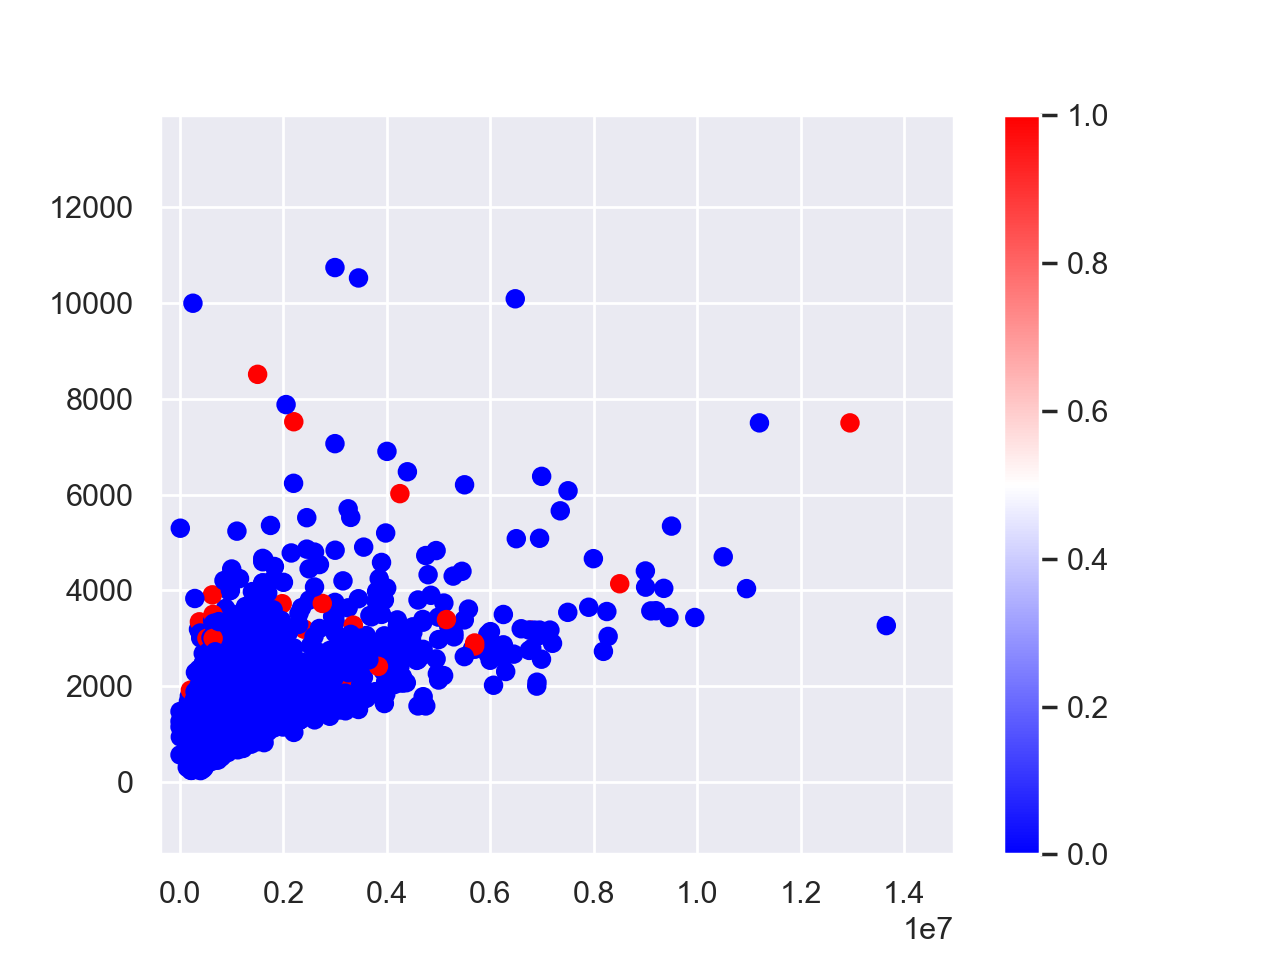

In [154]:
fig = plt.figure()
plt.scatter(df['LIST PRICE'],df['SQUARE FEET'],c=df['DAYS ON MKT']>465,cmap='bwr')
plt.colorbar()
plt.show()

        
        